In [1]:
!pip install googletrans==3.1.0a0 --upgrade --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 5.9 MB/s eta 0:00:00


In [2]:
# importing the important library
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk 
import re
import seaborn as sns
from googletrans import Translator, constants
from pprint import pprint
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from scipy.sparse import hstack
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
project_data = pd.read_csv('HOT_Dataset_modified.csv', encoding='utf-8', header=None)
project_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.0,@saud5683 @Mutayyab420 @shivang598 @Ranask35 @...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,"Banti hai empowered woman, feminism pe gyan pe...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,RT @kim_jong_korea: @updatingwait @Acutereply ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
project_data = project_data.dropna(how='all')

In [5]:
project_data = project_data.iloc[0::, 0:2]

In [6]:
project_data[0].value_counts()

2.0    1765
0.0    1121
1.0     303
Name: 0, dtype: int64

In [7]:
project_data.columns = ['label', 'tweet']

In [8]:
project_data.head()

,label,tweet
0,0.0,@saud5683 @Mutayyab420 @shivang598 @Ranask35 @...
2,2.0,"Banti hai empowered woman, feminism pe gyan pe..."
4,2.0,RT @kim_jong_korea: @updatingwait @Acutereply ...
6,2.0,@InviSibleSold @mabkhan86 @dridadahn Punjab in...
8,2.0,RT @MrMonsterSaid: Agar koi bole ki ja ke chil...


In [9]:
bad_words = pd.read_csv('Hinglish_Profanity_List.csv', encoding='utf-8', header=None)
bad_words

,0,1,2
0,badir,idiot,1
1,badirchand,idiot,1
2,bakland,idiot,1
3,bhadva,pimp,2
4,bhootnika,son of a witch,3
...,...,...,...
216,bhosadiwala,Whore's son,10
217,bhosadi,Whore's son,10
218,bhosdi,Whore's son,10
219,bhosidi,Whore's son,10


In [10]:
from googletrans import Translator
import re

# Hinglish tweet
hinglish_tweet = "Kya aapko yeh pasand hai?"

# Regular expression to match Hinglish words
hinglish_regex = r'[\u0900-\u097F]+'

# Extract Hinglish words from tweet
hinglish_words = re.findall(hinglish_regex, hinglish_tweet)

# Translate Hinglish words to English
translator = Translator(service_urls=['translate.google.com'])
english_words = []
for word in hinglish_words:
    english_word = translator.translate(word, dest='en').text
    english_words.append(english_word)

# Print the Hinglish and English words
print(hinglish_words)
print(english_words)


[]
[]


## Function for Data Cleaning

In [18]:
def userid(tweet):
    ''' This function calculates the number of userids in the tweets'''
    count = 0
    for i in tweet.split():
        if i[0] == '@':
            count += 1
    return count

def profanity_vector(tweet):
    
    ''' This functions calculates the profanity vector for a given tweet '''
    
    bad_words = pd.read_csv('Hinglish_Profanity_List.csv', encoding='utf-8',engine='python', header=None)
    bad_words.columns = ['Hinglish', 'English', 'Level']
    hinglish = bad_words['Hinglish'].values
    level = bad_words['Level'].values
    PV = [0] * len(level)
    for word in tweet.split():
        if word in hinglish:
            idx = np.where(hinglish == word)
            PV[level[idx][0]] = 1
    return PV

def translation(tweet):
    
    ''' This function translates the hinglish tweet into english '''
    
    
    translator = Translator()
    
    hinglish_regex = r'[\u0900-\u097F]+'

    # Extract Hinglish words from tweet
    hinglish_words = re.findall(hinglish_regex, tweet)
    
    if len(hinglish_words)==0:
        return tweet.lower()
    trans = translator.translate(tweet)
    trans_tweet = trans.text
    
    return trans_tweet.lower()

def stopword(data):
    
    ''' This function removes the stopwords from the given sentence'''
    clean = []
    stop_words = set(stopwords.words('english'))
    
    for tweet in data:
        sentence = []
        for word in tweet.split():
            if word not in stop_words:
                sentence.append(word)
        clean.append(sentence)
    return clean

def Lemmatizer(tweet):
    
    ''' This function uses NLTK lemmatization method and clean the sentence'''
    lemma = []
    lemmatizer = WordNetLemmatizer()
    
    for word in tweet:
        sentence = []
        for i in word:
             sentence.append(lemmatizer.lemmatize(i))
        lemma.append(' '.join(sentence))
    return lemma

def SID(tweet):
    
    ''' This function calculates the NLTK sentiments and return the negative, neutral, postive and compound values'''
    negative = []
    neutral = []
    positive = []
    compound = []
    
    sid = SentimentIntensityAnalyzer()
    sentiment_score = sid.polarity_scores(tweet)
    
    negative.append(sentiment_score['neg'])
    neutral.append(sentiment_score['neu'])
    positive.append(sentiment_score['pos'])
    compound.append(sentiment_score['compound'])
    
    return negative, neutral, positive, compound


def cleaning(data):
    
    ''' This functions clean the input text'''
    
    user_ids = []
    clean_data_hinglish = []
    clean_translated_data = []
    prof_vector = []
    
    for tweet in tqdm(data):
        userids = userid(tweet)
        clean_text = []
        tweet = re.sub(r'\\n', ' ', tweet)  # replacing '\\n' with a space
        tweet = re.sub(r',', ' ', tweet)    # replacing ','  with a space
        tweet = re.sub(r'RT|rt', '', tweet)
        
        for word in tweet.split():
            if word[0] == '@':              # removing user_ids 
                clean_word = re.sub(word, 'username', word)
            else:
                clean_word = word.lower()       # lowercase all the words
                clean_word = re.sub(r'^#\w+', ' ', clean_word)
                #clean_word = re.sub(r'^\\[a-z0-9].*\\[a-z0-9{3}+]*[^\\n]$', '', clean_word)   # removing emotions in unicode
                clean_word = re.sub(r'\\', ' ', clean_word)
                clean_word = re.sub(r'^https:[\a-zA-Z0-9]+', '', clean_word)              # replacing url link with 'url'
                #clean_word = re.sub(r'[^a-z].\w+', '', clean_word)           # removing evering thing except a-z
                clean_word = re.sub(r'[!,.:_;$%^\'\#"&]', '', clean_word)
                clean_text.append(clean_word)
                
        clean_text = (' ').join(clean_text)
    
        PV = profanity_vector(clean_text)  # calling profanity_vector function
        translated_tweet = translation(clean_text)  #calling translated_tweet function
        
        user_ids.append(userids)
        clean_data_hinglish.append(clean_text)
        clean_translated_data.append(translated_tweet)
        prof_vector.append(PV)
        
        
    clean_data_hinglish = np.asarray(clean_data_hinglish)
    user_ids = np.asarray(user_ids).reshape(-1,1)
    prof_vector = np.asarray(prof_vector)
    clean_translated_data = np.asarray(clean_translated_data)

        
    return clean_data_hinglish, user_ids, prof_vector, clean_translated_data

### Function for feature Engineering

In [12]:
def feature_process(clean_data_train, clean_data_test, userids_train, userids_test, PV_train, PV_test):
    ''' This function except the clean data and return Train and Test dataset after stacking userids, profanity vector, negative sentiment, neutral sentiment, 
                    positive sentiment, compound sentiment, n-grams and tfidf features'''
    
    vectorizer = CountVectorizer()
    tfidf = TfidfVectorizer()
    negative_train, negative_test = [], []
    neutral_train, neutral_test = [], []
    positive_train, positive_test  = [], []
    compound_train, compound_test  = [], []

    for tweet in clean_data_train:
        neg, neu, pos, comp = SID(tweet)
        negative_train.append(neg), neutral_train.append(neu), positive_train.append(pos), compound_train.append(comp)
    
    for tweet in clean_data_test:
        neg, neu, pos, comp = SID(tweet)
        negative_test.append(neg), neutral_test.append(neu), positive_test.append(pos), compound_test.append(comp)
    
    clean_data_SW_train = stopword(clean_data_train)
    clean_data_SW_test = stopword(clean_data_test)
    
    clean_data_lemm_train = Lemmatizer(clean_data_SW_train)
    clean_data_lemm_test = Lemmatizer(clean_data_SW_test)
    
    vectorizer.fit(clean_data_lemm_train)
    tfidf.fit(clean_data_lemm_train)
    
    n_grams_train = vectorizer.transform(clean_data_lemm_train)
    tfidf_ngrams_train = tfidf.transform(clean_data_lemm_train)
    
    n_grams_test = vectorizer.transform(clean_data_lemm_test)
    tfidf_ngrams_test = tfidf.transform(clean_data_lemm_test)
    
    negative_train, negative_test = np.asarray(negative_train), np.asarray(negative_test)
    neutral_train, neutral_test = np.asarray(neutral_train), np.asarray(neutral_test)
    positive_train, positive_test  = np.asarray(positive_train), np.asarray(positive_test)
    compound_train, compound_test = np.asarray(compound_train), np.asarray(compound_test)
    
    train_dataset = hstack((user_ids_train, PV_train, negative_train, neutral_train, positive_train, compound_train, n_grams_train, tfidf_ngrams_train))
    
    test_dataset = hstack((user_ids_test, PV_test, negative_test, neutral_test, positive_test, compound_test, n_grams_test, tfidf_ngrams_test))
    
    
    return train_dataset, test_dataset

## Spliting Train and Test Dataset into 80:20


In [13]:
X = project_data['tweet']
y = project_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) 

In [14]:
# calling the cleaning function which returns the values for the train dataset.

clean_data_hinglish_train, user_ids_train, prof_vector_train, clean_translated_data_train = cleaning(X_train)

100%|██████████| 2551/2551 [00:25<00:00, 101.53it/s]


In [15]:
# calling the cleaning function which returns the values for the test dataset

clean_data_hinglish_test, user_ids_test, prof_vector_test, clean_translated_data_test = cleaning(X_test)

100%|██████████| 638/638 [00:05<00:00, 113.60it/s]


In [19]:
#Calling feature_process which return the complete train and test dataset.
Train, Test = feature_process(clean_translated_data_train, clean_translated_data_test, user_ids_train, user_ids_test, prof_vector_train, prof_vector_test)

In [20]:
print('{} is the shape of Train Dataset and {} is the shape of Test Dataset'.format(Train.shape, Test.shape))

(2551, 13970) is the shape of Train Dataset and (638, 13970) is the shape of Test Dataset


## Trying our Models:

In [21]:
def plot_confusion_matrix(test_y, predict_y):
    
    '''This function returns confusion matrix, precison matrix and recall matrix for 3 class classification'''
    
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    
    labels = ['Non Offensive', 'Hate Speech', 'Abusive']
    cmap=sns.light_palette("green")
    
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix" , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in Recall matrix",A.sum(axis=1))

## 1. Support Vector Machine with Grid Search Cross Validation

## 1.1 Support Vector Machine with Linear Kernel

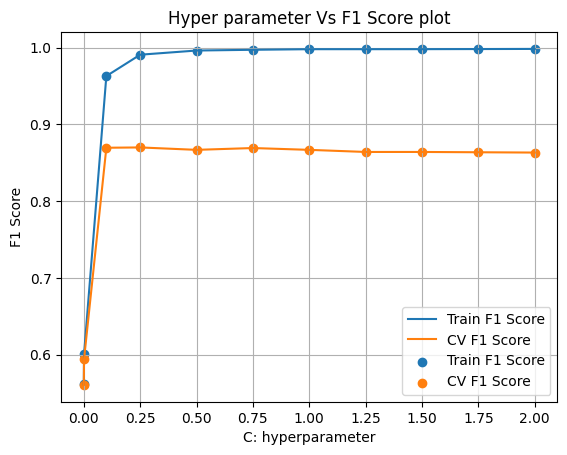

In [22]:
svm = SVC(gamma='auto')
parameters = {'C':[ 0.0001, 0.001, 0.1, 0.25, 0.50, 0.75, 1, 1.25, 1.5, 1.75, 2.0], 'kernel': ['linear']}
clf = GridSearchCV(svm, parameters, cv=10, scoring='f1_micro', return_train_score=True)
clf.fit(Train, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_C'])

train_score= results['mean_train_score']
cv_score = results['mean_test_score'] 
alpha =  results['param_C']

plt.plot(alpha, train_score, label='Train F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_score, label='CV F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(alpha, train_score, label='Train F1 Score')
plt.scatter(alpha, cv_score, label='CV F1 Score')


plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("F1 Score")
plt.title("Hyper parameter Vs F1 Score plot")
plt.grid()
plt.show()

In [ ]:
clf.best_params_

Number of misclassified points  13.322884012539186
-------------------------------------------------- Confusion matrix --------------------------------------------------


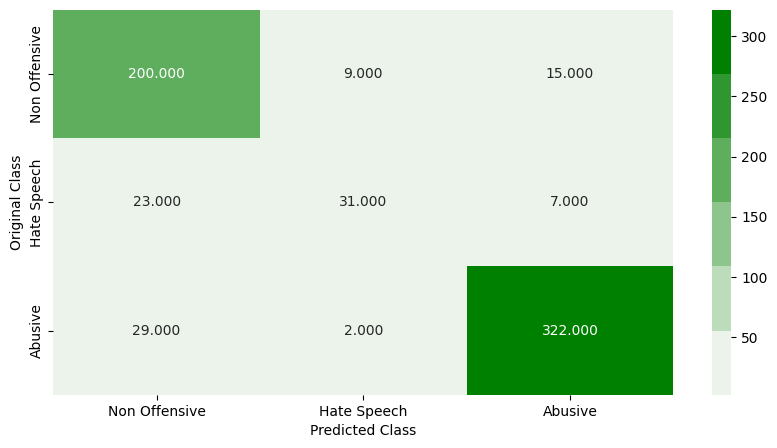

-------------------------------------------------- Precision matrix --------------------------------------------------


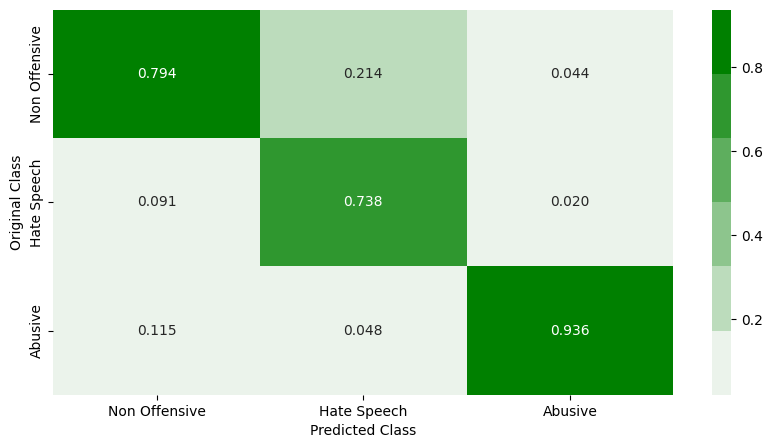

Sum of columns in precision matrix [1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


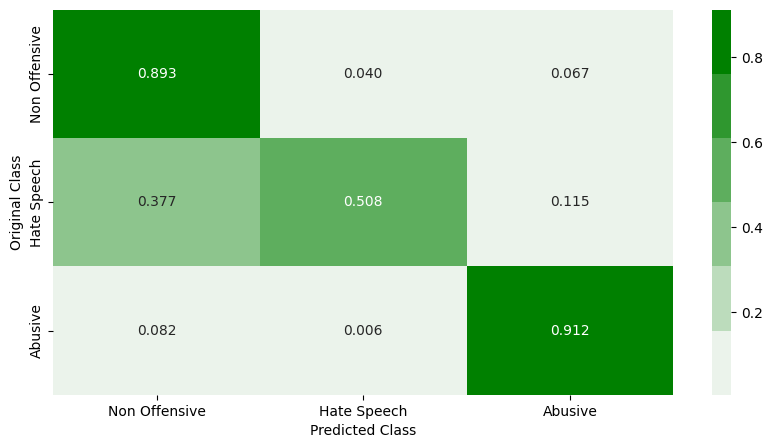

Sum of rows in Recall matrix [1. 1. 1.]


In [23]:
svm_clf = SVC(C=0.25, gamma='auto', kernel='linear')
svm_clf.fit(Train, y_train)
plot_confusion_matrix(y_test, svm_clf.predict(Test))

## 1.2 Support Vector Machine with RBF Kernel

In [ ]:
svm = SVC(kernel='rbf')
parameters = {'C':[ 0.0001, 0.001, 0.1, 0.25, 0.50, 0.75, 1, 1.25, 1.5, 1.75, 2.0, 4, 6, 8, 10, 12, 15, 20, 25], 'gamma':['scale', 'auto'],  }
clf = GridSearchCV(svm, parameters, cv=10, scoring='f1_micro', return_train_score=True)
clf.fit(Train, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_C'])

train_score= results['mean_train_score']
cv_score = results['mean_test_score'] 
alpha =  results['param_C']

plt.plot(alpha, train_score, label='Train F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_score, label='CV F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(alpha, train_score, label='Train F1 Score')
plt.scatter(alpha, cv_score, label='CV F1 Score')


plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("F1 Score")
plt.title("Hyper parameter Vs F1 Score plot")
plt.grid()
plt.show()

In [ ]:
clf.best_params_

In [ ]:
svm_clf_rbf = SVC(C=8, gamma='scale', kernel='rbf')
svm_clf_rbf.fit(Train, y_train)
plot_confusion_matrix(y_test, svm_clf_rbf.predict(Test))

## 1.3 Support Vector Machine with Polynominal Kernel

In [ ]:
svm = SVC(kernel='poly')
parameters = {'C':[ 0.0001, 0.001, 0.1, 1,  1.5, 2.0, 2.5, 3, 5, 8, 10, 15, 25, 50, 60, 75, 85, 95, 100, 110, 125, 150], \
              'gamma':['scale', 'auto'], 'degree': [2,3,4,5]  }
clf = GridSearchCV(svm, parameters, cv=10, scoring='f1_micro', return_train_score=True, n_jobs=-1)
clf.fit(Train, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_C'])

train_score= results['mean_train_score']
cv_score = results['mean_test_score'] 
alpha =  results['param_C']

plt.plot(alpha, train_score, label='Train F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_score, label='CV F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(alpha, train_score, label='Train F1 Score')
plt.scatter(alpha, cv_score, label='CV F1 Score')


plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("F1 Score")
plt.title("Hyper parameter Vs F1 Score plot")
plt.grid()
plt.show()

In [ ]:
clf.best_params_

Number of misclassified points  13.636363636363635
-------------------------------------------------- Confusion matrix --------------------------------------------------


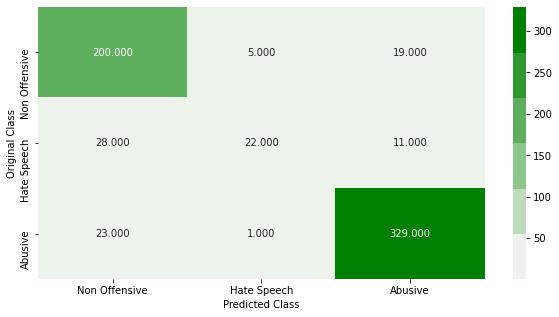

-------------------------------------------------- Precision matrix --------------------------------------------------


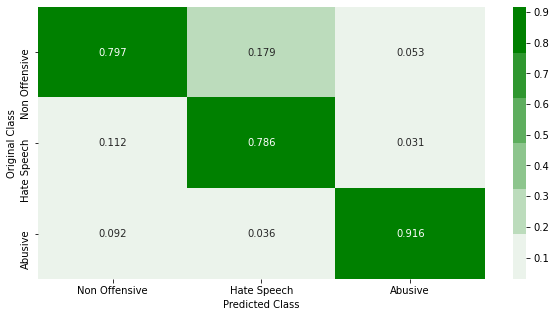

Sum of columns in precision matrix [1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


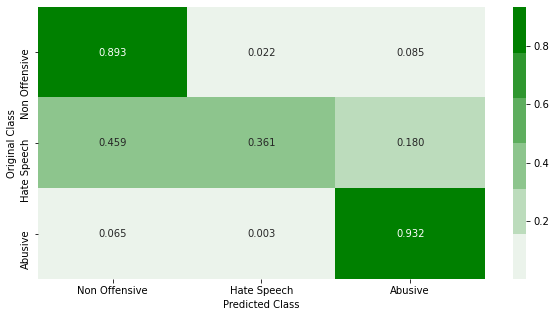

Sum of rows in Recall matrix [1. 1. 1.]


In [ ]:
svm_clf_poly = SVC(C=75, gamma='scale', degree=2, kernel='poly')
svm_clf_poly.fit(Train, y_train)
plot_confusion_matrix(y_test, svm_clf_poly.predict(Test))

## 2. Logistic Regression

C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:54

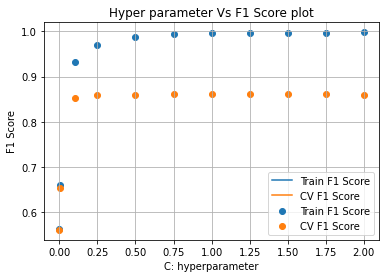

In [ ]:
LR = LogisticRegression(max_iter=500, random_state=42)
parameters = {'C':[ 0.0001, 0.001, 0.1, 0.25, 0.50, 0.75, 1, 1.25, 1.5, 1.75, 2.0], 'penalty':['l2']}

clf = GridSearchCV(LR, parameters, cv=10, scoring='f1_micro', return_train_score=True)
clf.fit(Train, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_C'])

train_score= results['mean_train_score']
cv_score = results['mean_test_score'] 
alpha =  results['param_C']

plt.plot(alpha, train_score, label='Train F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_score, label='CV F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(alpha, train_score, label='Train F1 Score')
plt.scatter(alpha, cv_score, label='CV F1 Score')

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("F1 Score")
plt.title("Hyper parameter Vs F1 Score plot")
plt.grid()
plt.show()

In [ ]:
clf.best_params_

{'C': 0.75, 'penalty': 'l2'}

Number of misclassified points  13.793103448275861
-------------------------------------------------- Confusion matrix --------------------------------------------------


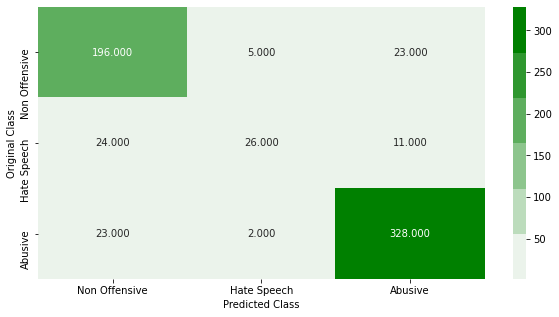

-------------------------------------------------- Precision matrix --------------------------------------------------


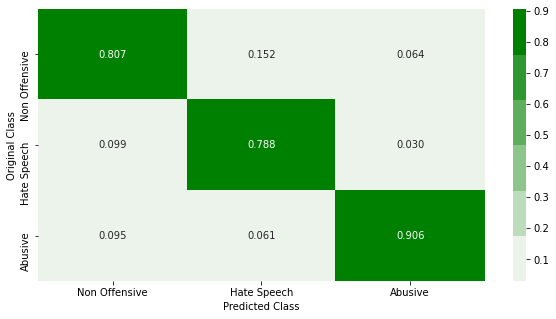

Sum of columns in precision matrix [1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


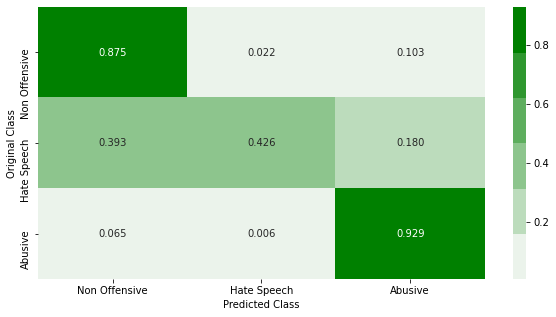

Sum of rows in Recall matrix [1. 1. 1.]


In [ ]:
LR_clf = LogisticRegression(C= 0.75, max_iter=500, penalty='l2', random_state=42)
LR_clf.fit(Train, y_train)
plot_confusion_matrix(y_test, LR_clf.predict(Test))

## 3. Decision Tree Classifier

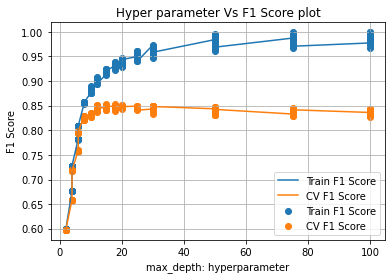

In [ ]:
from sklearn.tree import DecisionTreeClassifier

DTC = DecisionTreeClassifier()
parameters = {'criterion':['gini', 'entropy'], 'max_depth': [2, 4, 6, 8, 10, 12, 15, 18, 20, 25, 30, 50, 75, 100], \
             'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 10]}
clf = GridSearchCV(DTC, parameters, cv=10, scoring='f1_micro', n_jobs=-1, return_train_score=True)
clf.fit(Train, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_max_depth'])

train_score= results['mean_train_score']
cv_score = results['mean_test_score'] 
alpha =  results['param_max_depth']

plt.plot(alpha, train_score, label='Train F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_score, label='CV F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(alpha, train_score, label='Train F1 Score')
plt.scatter(alpha, cv_score, label='CV F1 Score')

plt.legend()
plt.xlabel("max_depth: hyperparameter")
plt.ylabel("F1 Score")
plt.title("Hyper parameter Vs F1 Score plot")
plt.grid()
plt.show()


In [ ]:
clf.best_params_

{'criterion': 'gini', 'max_depth': 18, 'min_samples_split': 2}

Number of misclassified points  15.360501567398119
-------------------------------------------------- Confusion matrix --------------------------------------------------


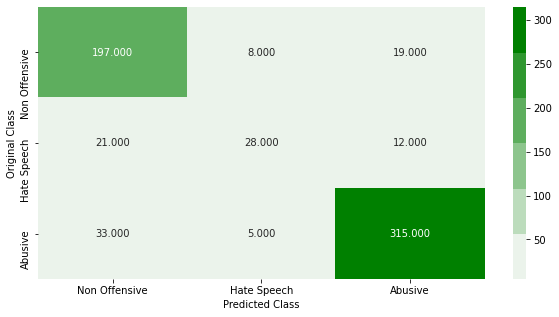

-------------------------------------------------- Precision matrix --------------------------------------------------


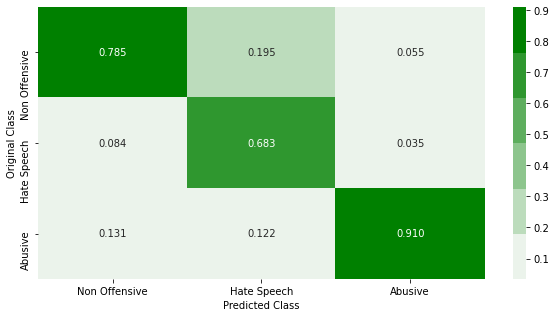

Sum of columns in precision matrix [1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


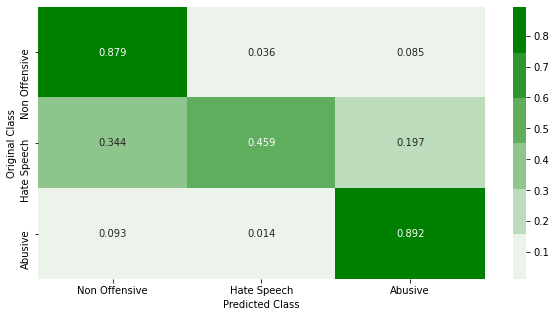

Sum of rows in Recall matrix [1. 1. 1.]


In [ ]:
DTC_clf = DecisionTreeClassifier(criterion='gini', max_depth=18, min_samples_split=2)
DTC_clf.fit(Train, y_train)
plot_confusion_matrix(y_test, DTC_clf.predict(Test))

## 4. K - Nearest Neighbour Classifier

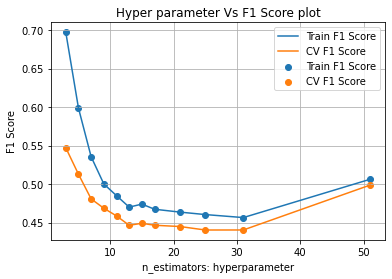

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
KNN = KNeighborsClassifier()
parameters = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15, 17, 21, 25, 31, 51, ]}
clf = GridSearchCV(KNN, parameters, cv=10, scoring='f1_macro', n_jobs=-1, return_train_score=True)
clf.fit(Train, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_n_neighbors'])

train_score= results['mean_train_score']
cv_score = results['mean_test_score'] 
alpha =  results['param_n_neighbors']

plt.plot(alpha, train_score, label='Train F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_score, label='CV F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(alpha, train_score, label='Train F1 Score')
plt.scatter(alpha, cv_score, label='CV F1 Score')

plt.legend()
plt.xlabel("n_neighbors: hyperparameter")
plt.ylabel("F1 Score")
plt.title("Hyper parameter Vs F1 Score plot")
plt.grid()
plt.show()

In [ ]:
clf.best_params_

{'n_neighbors': 3}

Number of misclassified points  27.11598746081505
-------------------------------------------------- Confusion matrix --------------------------------------------------


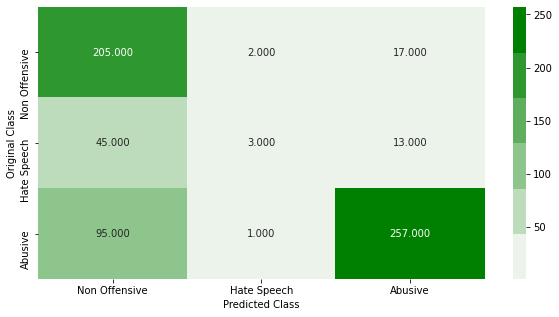

-------------------------------------------------- Precision matrix --------------------------------------------------


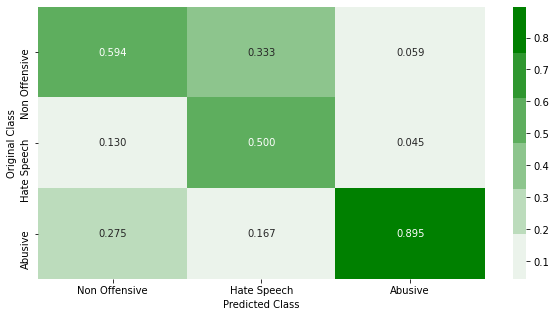

Sum of columns in precision matrix [1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


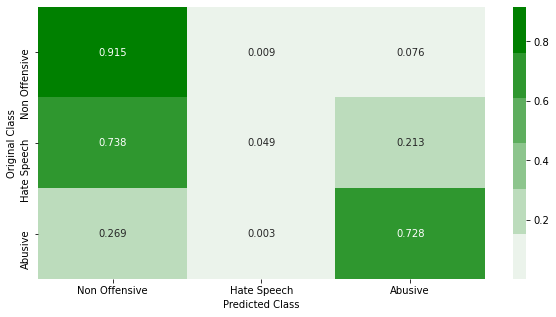

Sum of rows in Recall matrix [1. 1. 1.]


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
KNN_clf = KNeighborsClassifier(n_neighbors=3)
KNN_clf.fit(Train, y_train)
plot_confusion_matrix(y_test, KNN_clf.predict(Test))

## 5. Random Forest Classifier

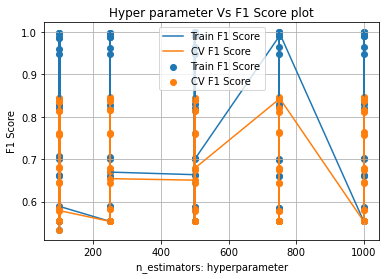

In [ ]:
RF = RandomForestClassifier(n_jobs=-1)
parameters={
     'n_estimators': [100, 250, 500, 750, 1000],
     'max_depth': [5,8,10, 20, 50, 100, 250, 500 ],
    'max_samples' : [0.6, 0.75, 1],
}
clf = GridSearchCV(RF, parameters, cv=10, scoring='f1_micro', n_jobs=-1, return_train_score=True)
clf.fit(Train, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_n_estimators'])

train_score= results['mean_train_score']
cv_score = results['mean_test_score'] 
alpha =  results['param_n_estimators']

plt.plot(alpha, train_score, label='Train F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_score, label='CV F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(alpha, train_score, label='Train F1 Score')
plt.scatter(alpha, cv_score, label='CV F1 Score')

plt.legend()
plt.xlabel("n_estimators: hyperparameter")
plt.ylabel("F1 Score")
plt.title("Hyper parameter Vs F1 Score plot")
plt.grid()
plt.show()

In [ ]:
clf.best_params_

{'max_depth': 250, 'max_samples': 0.75, 'n_estimators': 250}

Number of misclassified points  15.987460815047022
-------------------------------------------------- Confusion matrix --------------------------------------------------


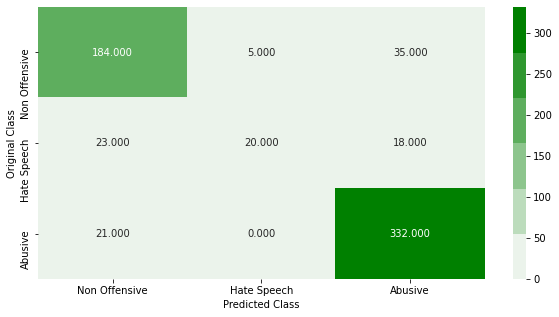

-------------------------------------------------- Precision matrix --------------------------------------------------


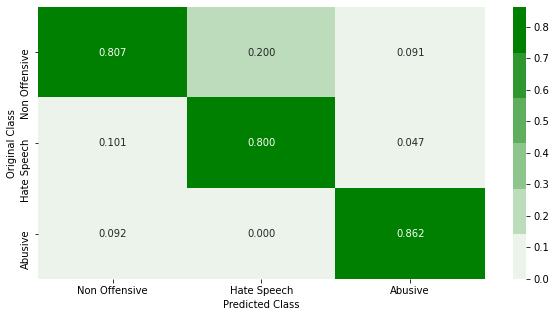

Sum of columns in precision matrix [1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


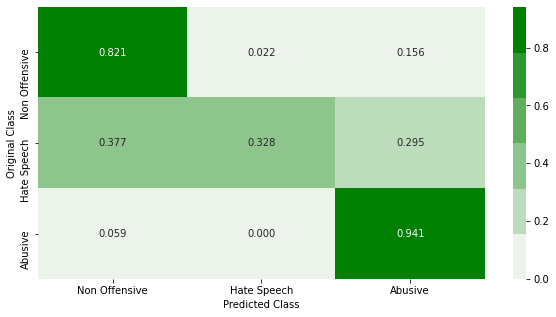

Sum of rows in Recall matrix [1. 1. 1.]


In [ ]:
RF_clf = RandomForestClassifier(n_estimators=250, max_depth=250, max_samples=0.75, n_jobs=-1)
RF_clf.fit(Train, y_train)
plot_confusion_matrix(y_test, RF_clf.predict(Test))

## 6. XGBOOST Classifier

In [ ]:
from xgboost import XGBClassifier
XGB = XGBClassifier()
parameters={
    'learning_rate':[0.0001, 0.001, 0.01, 0.1, 1, 2, 3, 5],
     'n_estimators':[100, 250, 500, 750, 1000],
     'max_depth':[5, 10, 20, 50, 100, 200, 350, 500],
    'colsample_bytree' : [0.6, 0.75, 1],
    'subsample': [0.6, 0.75, 1]
}

clf = GridSearchCV(XGB, parameters, cv=5, scoring='f1_macro', n_jobs=-1, return_train_score=True)
clf.fit(Train, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_n_estimators'])

train_score= results['mean_train_score']
cv_score = results['mean_test_score'] 
alpha =  results['param_n_estimators']

plt.plot(alpha, train_score, label='Train F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_score, label='CV F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(alpha, train_score, label='Train F1 Score')
plt.scatter(alpha, cv_score, label='CV F1 Score')

plt.legend()
plt.xlabel("n_estimators: hyperparameter")
plt.ylabel("F1 Score")
plt.title("Hyper parameter Vs F1 Score plot")
plt.grid()
plt.show()

In [ ]:
clf.best_params_

Number of misclassified points  12.225705329153605
-------------------------------------------------- Confusion matrix --------------------------------------------------


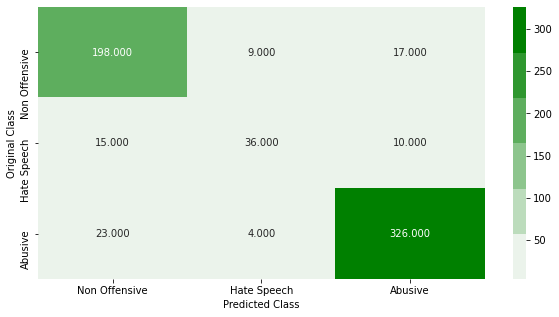

-------------------------------------------------- Precision matrix --------------------------------------------------


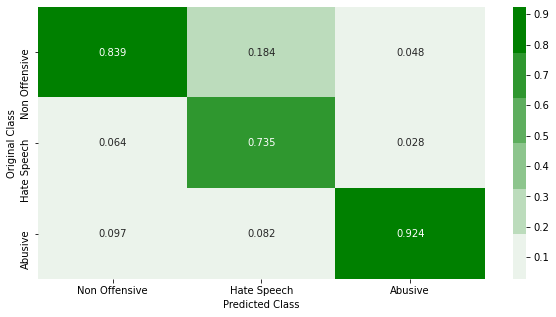

Sum of columns in precision matrix [1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


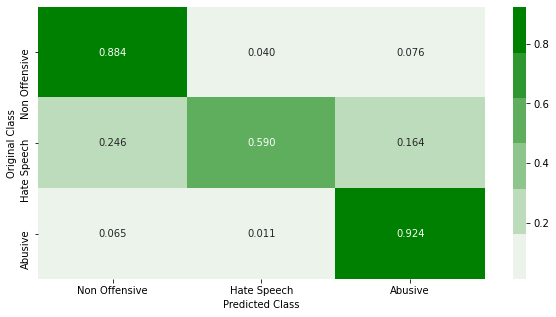

Sum of rows in Recall matrix [1. 1. 1.]


In [ ]:

XGB_clf = XGBClassifier(depth= 10, learning_rate =0.75, iterations=100, n_jobs=-1)
XGB_clf.fit(Train, y_train)
plot_confusion_matrix(y_test, XGB_clf.predict(Test))

## Summary

In [ ]:
from prettytable import PrettyTable
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score
myTable = PrettyTable(["Model","Train / Test", "Accuray", "F1-Score", "Precison", "Recall"])
  
# Add rows
myTable.add_row(["KNN", "Train", np.round(accuracy_score(y_train, KNN_clf.predict(Train)), 6), np.round(f1_score(y_train, KNN_clf.predict(Train),\
                average='macro'), 6), np.round(precision_score(y_train, KNN_clf.predict(Train), average='macro'), 6), \
                 np.round(recall_score(y_train, KNN_clf.predict(Train), average='macro'), 6)])

myTable.add_row(["KNN", "Test", np.round(accuracy_score(y_test, svm_clf.predict(Test)), 6), np.round(f1_score(y_test, svm_clf.predict(Test),\
                average='macro'), 6), np.round(precision_score(y_test, svm_clf.predict(Test), average='macro'), 6), \
                 np.round(recall_score(y_test, svm_clf.predict(Test), average='macro'), 6)])

myTable.add_row(["SVC-Linear", "Train", np.round(accuracy_score(y_train, svm_clf.predict(Train)), 6), np.round(f1_score(y_train, svm_clf.predict(Train),\
                average='macro'), 6), np.round(precision_score(y_train, svm_clf.predict(Train), average='macro'), 6), \
                 np.round(recall_score(y_train, svm_clf.predict(Train), average='macro'), 6)])

myTable.add_row(["SVC-Linear", "Test", np.round(accuracy_score(y_test, svm_clf.predict(Test)), 6), np.round(f1_score(y_test, svm_clf.predict(Test),\
                average='macro'), 6), np.round(precision_score(y_test, svm_clf.predict(Test), average='macro'), 6), \
                 np.round(recall_score(y_test, svm_clf.predict(Test), average='macro'), 6)])

myTable.add_row(["SVC-RBF", "Train", np.round(accuracy_score(y_train, svm_clf_rbf.predict(Train)), 6), np.round(f1_score(y_train, svm_clf_rbf.predict(Train),\
                average='macro'), 6), np.round(precision_score(y_train, svm_clf_rbf.predict(Train), average='macro'), 6), \
                 np.round(recall_score(y_train, svm_clf_rbf.predict(Train), average='macro'), 6)])

myTable.add_row(["SVC-RBF", "Test", np.round(accuracy_score(y_test, svm_clf_rbf.predict(Test)), 6), np.round(f1_score(y_test, svm_clf_rbf.predict(Test),\
                average='macro'), 6), np.round(precision_score(y_test, svm_clf_rbf.predict(Test), average='macro'), 6), \
                 np.round(recall_score(y_test, svm_clf_rbf.predict(Test), average='macro'), 6)])

myTable.add_row(["SVC-Poly", "Train", np.round(accuracy_score(y_train, svm_clf_poly.predict(Train)), 6), np.round(f1_score(y_train, svm_clf_poly.predict(Train),\
                average='macro'), 6), np.round(precision_score(y_train, svm_clf_poly.predict(Train), average='macro'), 6), \
                 np.round(recall_score(y_train, svm_clf_poly.predict(Train), average='macro'), 6)])

myTable.add_row(["SVC-Poly", "Test", np.round(accuracy_score(y_test, svm_clf_poly.predict(Test)), 6), np.round(f1_score(y_test, svm_clf_poly.predict(Test),\
                average='macro'), 6), np.round(precision_score(y_test, svm_clf_poly.predict(Test), average='macro'), 6), \
                 np.round(recall_score(y_test, svm_clf_poly.predict(Test), average='macro'), 6)])

myTable.add_row(["Logistic Regression","Train", np.round(accuracy_score(y_train, LR_clf.predict(Train)), 6), np.round(f1_score(y_train, LR_clf.predict(Train),\
                average='macro'), 6), np.round(precision_score(y_train, LR_clf.predict(Train), average='macro'), 6),\
                 np.round(recall_score(y_train, LR_clf.predict(Train), average='macro'), 6)])

myTable.add_row(["Logistic Regression","Test", np.round(accuracy_score(y_test, LR_clf.predict(Test)), 6), np.round(f1_score(y_test, LR_clf.predict(Test),\
                average='macro'), 6), np.round(precision_score(y_test, LR_clf.predict(Test), average='macro'), 6),\
                 np.round(recall_score(y_test, LR_clf.predict(Test), average='macro'), 6)])

myTable.add_row(["Decision Tree","Train", np.round(accuracy_score(y_train, DTC_clf.predict(Train)), 6), np.round(f1_score(y_train, DTC_clf.predict(Train),\
                average='macro'), 6), np.round(precision_score(y_train, DTC_clf.predict(Train), average='macro'), 6),\
                 np.round(recall_score(y_train, DTC_clf.predict(Train), average='macro'), 6)])

myTable.add_row(["Decision Tree","Test", np.round(accuracy_score(y_test, DTC_clf.predict(Test)), 6), np.round(f1_score(y_test, DTC_clf.predict(Test),\
                average='macro'), 6), np.round(precision_score(y_test, DTC_clf.predict(Test), average='macro'), 6),\
                 np.round(recall_score(y_test, DTC_clf.predict(Test), average='macro'), 6)])

myTable.add_row(["Random Forest","Train", np.round(accuracy_score(y_train, RF_clf.predict(Train)), 6), np.round(f1_score(y_train, RF_clf.predict(Train),\
                average='macro'), 6), np.round(precision_score(y_train, RF_clf.predict(Train), average='macro'), 6),\
                 np.round(recall_score(y_train, RF_clf.predict(Train), average='macro'), 6)])

myTable.add_row(["Random Forest","Test", np.round(accuracy_score(y_test, RF_clf.predict(Test)), 6), np.round(f1_score(y_test, RF_clf.predict(Test),\
                average='macro'), 6), np.round(precision_score(y_test, RF_clf.predict(Test), average='macro'), 6),\
                 np.round(recall_score(y_test, RF_clf.predict(Test), average='macro'), 6)])

myTable.add_row(["XGBOOST","Train", np.round(accuracy_score(y_train, XGB_clf.predict(Train)), 6), np.round(f1_score(y_train, XGB_clf.predict(Train),\
                average='macro'), 6), np.round(precision_score(y_train, XGB_clf.predict(Train), average='macro'), 6),\
                 np.round(recall_score(y_train, XGB_clf.predict(Train), average='macro'), 6)])

myTable.add_row(["XGBOOST","Test", np.round(accuracy_score(y_test, XGB_clf.predict(Test)), 6), np.round(f1_score(y_test, XGB_clf.predict(Test),\
                average='macro'), 6), np.round(precision_score(y_test, XGB_clf.predict(Test), average='macro'), 6),\
                 np.round(recall_score(y_test, XGB_clf.predict(Test), average='macro'), 6)])
print(myTable)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


+---------------------+--------------+----------+----------+----------+----------+
|        Model        | Train / Test | Accuray  | F1-Score | Precison |  Recall  |
+---------------------+--------------+----------+----------+----------+----------+
|         KNN         |    Train     | 0.820463 | 0.694628 | 0.858224 | 0.680417 |
|         KNN         |     Test     | 0.871473 | 0.792185 | 0.840936 | 0.767216 |
|      SVC-Linear     |    Train     | 0.989024 | 0.983185 | 0.989127 | 0.977604 |
|      SVC-Linear     |     Test     | 0.871473 | 0.792185 | 0.840936 | 0.767216 |
|       SVC-RBF       |    Train     | 0.990592 | 0.985573 | 0.991417 | 0.980096 |
|       SVC-RBF       |     Test     | 0.873041 | 0.789207 | 0.840219 | 0.764184 |
|       SVC-Poly      |    Train     | 0.993336 | 0.989978 | 0.992576 | 0.987455 |
|       SVC-Poly      |     Test     | 0.863636 | 0.753548 | 0.832987 | 0.728508 |
| Logistic Regression |    Train     | 0.990984 | 0.984856 |  0.9923  | 0.977914 |
| Lo

From above ALL First cut model: Our XGBOOST is performing well overall specially for Hate Speech category. As our Hate Speech category is very less in number. More Data for Hate Speech will be helpful to increase overall model performance.  